<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/DeepLearning_ComputerVision_ImageClassification_Keras_DataSpartan_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MultiLabel Image Classification 

In this notebook we generate a model in `keras` to try to classify images of figure (from a **non public dataset**).

Adapted from [link](https://www.kaggle.com/prateek0x/multiclass-image-classification-using-keras/notebook)

In [4]:
# Importing modules 
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import shutil
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from keras.utils import to_categorical
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Dataset

### Download data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
dataset_folderpath = "/content/input"

In [5]:
if os.path.isdir(dataset_folderpath):
  !rm -R {dataset_folderpath}

In [6]:
from pathlib import Path
def mkdir(sfolderpath):
  folderpath = Path(sfolderpath)
  folderpath.mkdir(parents=True, exist_ok=True)

mkdir(dataset_folderpath)

In [7]:
!tar -xvf /content/drive/My\ Drive/DATASPARTAN/PROYECTOS/AI-DOCUMENTS/SEGMENTATION/DSFigureDataset.tar.gz -C {dataset_folderpath}

clear_output()

!ls {dataset_folderpath}

raw  setup.py


### Split `train`, `val` and `test` dataset

The `zip` contains a script to generate the ml dataset

In [8]:
% cd {dataset_folderpath}
!python setup.py
% cd /content/

/content/input
Number of classes : 20
['GeneralFigure', 'Signatures', 'Table', 'Map', 'VennDiagram', 'RadarPlot', 'ScatterGraph', 'NetworkDiagram', 'VerticalBarGraph', 'PersonPhoto', 'LineGraph', 'BoxPlot', 'GeneralPhoto', 'AreaGraph', 'TreeDiagram', 'PieChart', 'ParetoChart', 'BubbleChart', 'FlowChart', 'HorizontalBarGraph']
GeneralFigure: 
   > ntrain : 175
   > nval : 72
   > ntest : 3

Signatures: 
   > ntrain : 186
   > nval : 77
   > ntest : 3

Table: 
   > ntrain : 75
   > nval : 31
   > ntest : 2

Map: 
   > ntrain : 271
   > nval : 113
   > ntest : 4

VennDiagram: 
   > ntrain : 213
   > nval : 88
   > ntest : 4

RadarPlot: 
   > ntrain : 160
   > nval : 66
   > ntest : 3

ScatterGraph: 
   > ntrain : 146
   > nval : 60
   > ntest : 3

NetworkDiagram: 
   > ntrain : 183
   > nval : 76
   > ntest : 3

VerticalBarGraph: 
   > ntrain : 251
   > nval : 105
   > ntest : 4

PersonPhoto: 
   > ntrain : 160
   > nval : 66
   > ntest : 3

LineGraph: 
   > ntrain : 156
   > nval : 65
  

In [9]:
!ls input/dataset

test  test_raw	train  val


In [10]:
input_folder = "/content/input/dataset"

trn_folder = os.path.join(input_folder,"train")
val_folder = os.path.join(input_folder,"val")
test_folder = os.path.join(input_folder,"test")
testraw_folder = os.path.join(input_folder,"test_raw")

In [11]:
classes = [name for name in os.listdir(trn_folder) 
      if os.path.isdir(os.path.join(trn_folder,name))]
print(f"Number of classes : {len(classes)}")
print(classes)

Number of classes : 20
['GeneralFigure', 'Signatures', 'Table', 'Map', 'VennDiagram', 'RadarPlot', 'ScatterGraph', 'NetworkDiagram', 'VerticalBarGraph', 'PersonPhoto', 'LineGraph', 'BoxPlot', 'GeneralPhoto', 'AreaGraph', 'TreeDiagram', 'PieChart', 'ParetoChart', 'BubbleChart', 'FlowChart', 'HorizontalBarGraph']


In [12]:
# Output of script
total_test=62

### Data preparation

Train and Val files are distributed in each folder with subfolders by class:

```
 folder\
    cls1\
        image.png
        image2.jpeg
        image3.png
        ...
    cls2\
        imageA.jpeg
        imageB.jpg
        imageC.png
        ...
    ...
```

We resize all the images to the same size.

In [13]:
IMG_HEIGHT = 550
IMG_WIDTH = 550
batch_size = 24

In [14]:
# With transform
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [15]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=trn_folder,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

Found 3520 images belonging to 20 classes.


In [16]:
total_train=len(train_data_gen.filenames)
total_train

3520

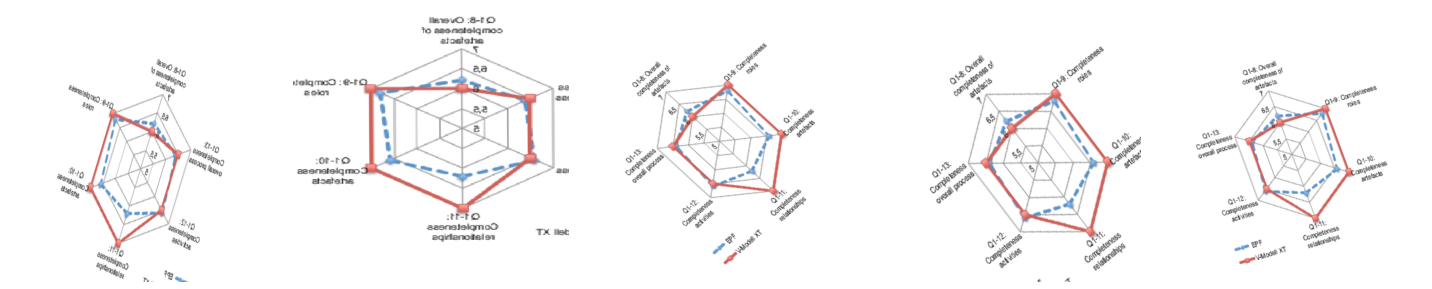

In [17]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [18]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [19]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_folder,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical')

Found 1458 images belonging to 20 classes.


In [20]:
total_val=len(val_data_gen.filenames)
total_val

1458

The `test` dataset is a list of images in a folder without associated label.

In [21]:
test_images = []
shape = (IMG_HEIGHT,IMG_WIDTH)

for filename in os.listdir(testraw_folder):
  img = cv2.imread(os.path.join(testraw_folder,filename))

  # Resize all images to a specific shape
  img = cv2.resize(img,shape)

  test_images.append(img)
        
# Converting test_images to array
test_images = np.array(test_images)

## Model

In [27]:
# Creating a Sequential model
model= Sequential()
model.add(Conv2D(kernel_size=(3,3), filters=32, activation='tanh', input_shape=(IMG_HEIGHT,IMG_WIDTH,3,)))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='tanh'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='tanh'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='tanh'))

model.add(Flatten())

model.add(Dense(80,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(len(classes),activation = 'softmax'))
    
model.compile(
              loss='categorical_crossentropy', 
              metrics=['acc'],
              optimizer='adam'
             )

In [28]:
# Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 548, 548, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 546, 546, 30)      8670      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 273, 273, 30)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 271, 271, 30)      8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 135, 135, 30)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 133, 133, 30)      8130      
_________________________________________________________________
flatten_1 (Flatten)          (None, 530670)           

In [ ]:
# Training the model
history = model.fit(
    train_data_gen,
    epochs=50,
    steps_per_epoch=total_train // batch_size,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size)

Epoch 1/1
  2/146 [..............................] - ETA: 1:28:09 - loss: 70.7226 - acc: 0.0208

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 13/146 [=>............................] - ETA: 57:20 - loss: 53.0827 - acc: 0.0609

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 22/146 [===>..........................] - ETA: 51:33 - loss: 37.9693 - acc: 0.0549

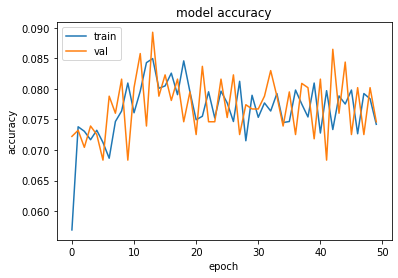

In [28]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

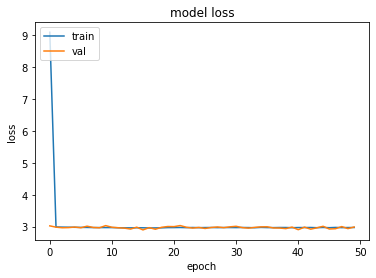

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation

In [24]:
val_images = []
val_labels = []
for classname in os.listdir(val_folder):
    classfolder = os.path.join(val_folder, classname)
    for filename in os.listdir(classfolder):
        img = cv2.imread(os.path.join(classfolder,filename))
        
        # Resize all images to a specific shape
        img = cv2.resize(img,shape)
        
        val_images.append(img)
        val_labels.append(classname)

# Converting train_images to array
val_images = np.array(val_images)
val_labels = np.array(val_labels)

In [ ]:
# Evaluating model on validation data
evaluate = model.evaluate(val_images,val_labels)
print(evaluate)

## Prediction

Predicted :-  VerticalBarGraph


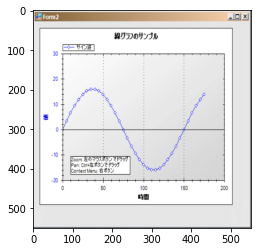

In [ ]:
checkImage = test_images[0:1]

predict = model.predict(np.array(checkImage))

print("Predicted :- ",classes[np.argmax(predict)])
plt.imshow(checkImage[0])